<a href="https://colab.research.google.com/github/ngochif/fngochi_64061/blob/main/Assignment_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Assignment - Time Series**

**Data Preparation**

In [1]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2024-04-07 01:05:20--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 16.182.41.232, 52.216.56.224, 52.217.1.134, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|16.182.41.232|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  58.3MB/s    in 0.2s    

2024-04-07 01:05:20 (58.3 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


***Inspecting the data***

In [2]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


***Parsing the data***

In [3]:
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

***Plotting the temperature timeseries***

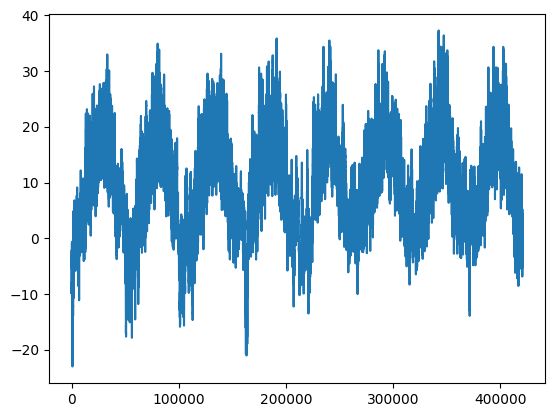

In [4]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)

***Splitting train, validation and test samples***

In [5]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


***Normalizing Data***

In [6]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [8]:
import numpy as np
from tensorflow import keras
int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


***Instantiating dataset***

In [9]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

**Training and Testing Original Model**

Training

In [11]:
from tensorflow import keras
from tensorflow.keras import layers
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.GRU(32, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout_original.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_stacked_gru_dropout_original.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/50
819/819 [==============================] - 310s 372ms/step - loss: 27.3849 - mae: 3.8268 - val_loss: 9.7472 - val_mae: 2.4227
Epoch 2/50
819/819 [==============================] - 289s 353ms/step - loss: 14.0189 - mae: 2.8949 - val_loss: 8.9462 - val_mae: 2.3229
Epoch 3/50
819/819 [==============================] - 283s 345ms/step - loss: 13.1383 - mae: 2.8120 - val_loss: 9.4118 - val_mae: 2.3877
Epoch 4/50
819/819 [==============================] - 276s 337ms/step - loss: 12.5235 - mae: 2.7451 - val_loss: 9.4429 - val_mae: 2.3945
Epoch 5/50
819/819 [==============================] - 314s 383ms/step - loss: 12.1121 - mae: 2.6999 - val_loss: 8.9298 - val_mae: 2.3218
Epoch 6/50
819/819 [==============================] - 311s 378ms/step - loss: 11.6557 - mae: 2.6522 - val_loss: 8.7014 - val_mae: 2.2851
Epoch 7/50
819/819 [==============================] - 308s 376ms/step - loss: 11.2648 - mae: 2.6077 - val_loss: 8.9762 - val_mae: 2.3288
Epoch 8/50
819/819 [=====================

Plotting Original Stacked Model

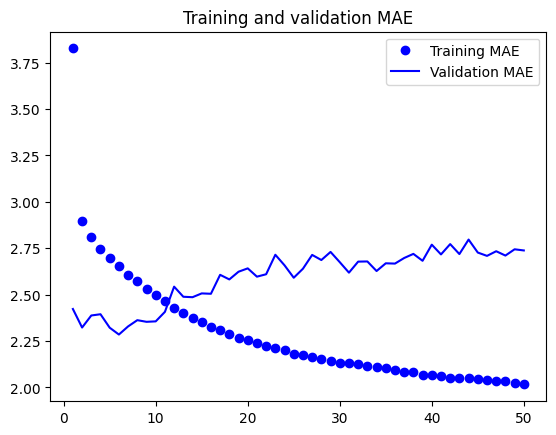

In [12]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE Original")
plt.plot(epochs, val_loss, "b", label="Validation MAE Original")
plt.title("Training and validation MAE Original")
plt.legend()
plt.show()

**Changing the Number of Units in the Recurrent Layer**

***Using Fewer Units***

In [18]:
from tensorflow import keras
from tensorflow.keras import layers
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(18, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.GRU(18, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_stacked_gru_dropout.keras")


Epoch 1/50
819/819 [==============================] - 295s 353ms/step - loss: 37.7887 - mae: 4.5239 - val_loss: 11.4169 - val_mae: 2.5632
Epoch 2/50
819/819 [==============================] - 286s 349ms/step - loss: 17.4907 - mae: 3.2132 - val_loss: 9.1438 - val_mae: 2.3355
Epoch 3/50
819/819 [==============================] - 284s 346ms/step - loss: 16.1913 - mae: 3.0955 - val_loss: 9.1444 - val_mae: 2.3514
Epoch 4/50
819/819 [==============================] - 284s 346ms/step - loss: 15.4279 - mae: 3.0231 - val_loss: 8.9417 - val_mae: 2.3206
Epoch 5/50
819/819 [==============================] - 286s 349ms/step - loss: 14.7899 - mae: 2.9656 - val_loss: 9.1395 - val_mae: 2.3562
Epoch 6/50
819/819 [==============================] - 281s 343ms/step - loss: 14.3602 - mae: 2.9235 - val_loss: 8.9083 - val_mae: 2.3174
Epoch 7/50
819/819 [==============================] - 284s 347ms/step - loss: 13.9453 - mae: 2.8792 - val_loss: 8.6097 - val_mae: 2.2841
Epoch 8/50
819/819 [====================

In [19]:
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 [==============================] - 38s 91ms/step - loss: 9.6414 - mae: 2.4304
Test MAE: 2.43


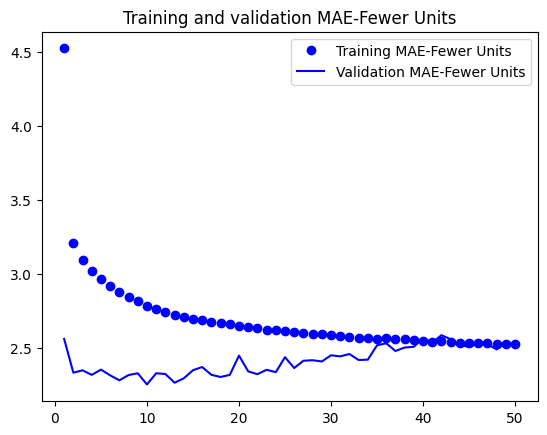

In [20]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE-Fewer Units")
plt.plot(epochs, val_loss, "b", label="Validation MAE-Fewer Units")
plt.title("Training and validation MAE-Fewer Units")
plt.legend()
plt.show()

***Using More Units***

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(50, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.GRU(50, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout_more_units.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_stacked_gru_dropout_more_units.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

In [10]:
from tensorflow import keras
from tensorflow.keras import layers
model = keras.models.load_model("jena_stacked_gru_dropout_more_units.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 [==============================] - 61s 147ms/step - loss: 9.9202 - mae: 2.4668
Test MAE: 2.47


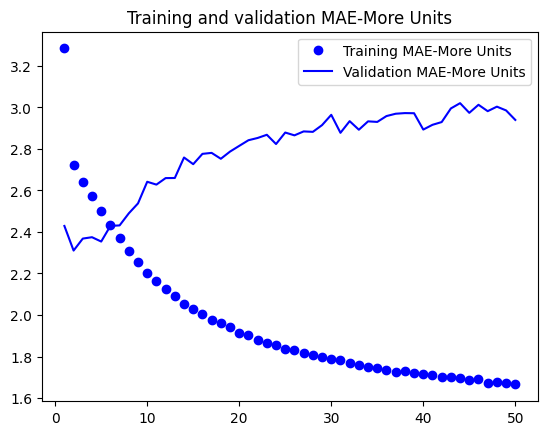

In [11]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE-More Units")
plt.plot(epochs, val_loss, "b", label="Validation MAE-More Units")
plt.title("Training and validation MAE-More Units")
plt.legend()
plt.show()

**Using LSTM instead of GRU**

In [10]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.LSTM(32, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_lstm_dropout.keras",
                                    save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_stacked_lstm_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/50
819/819 [==============================] - 445s 535ms/step - loss: 28.2928 - mae: 3.9088 - val_loss: 10.1634 - val_mae: 2.4900
Epoch 2/50
819/819 [==============================] - 392s 478ms/step - loss: 13.8385 - mae: 2.8822 - val_loss: 9.3472 - val_mae: 2.3779
Epoch 3/50
819/819 [==============================] - 390s 475ms/step - loss: 12.6580 - mae: 2.7552 - val_loss: 9.3297 - val_mae: 2.3811
Epoch 4/50
819/819 [==============================] - 429s 524ms/step - loss: 11.8036 - mae: 2.6647 - val_loss: 9.4776 - val_mae: 2.4108
Epoch 5/50
819/819 [==============================] - 426s 520ms/step - loss: 11.1780 - mae: 2.5884 - val_loss: 10.0706 - val_mae: 2.4846
Epoch 6/50
819/819 [==============================] - 426s 520ms/step - loss: 10.5968 - mae: 2.5204 - val_loss: 10.3521 - val_mae: 2.5188
Epoch 7/50
819/819 [==============================] - 423s 516ms/step - loss: 10.0642 - mae: 2.4534 - val_loss: 10.6092 - val_mae: 2.5538
Epoch 8/50
819/819 [=================

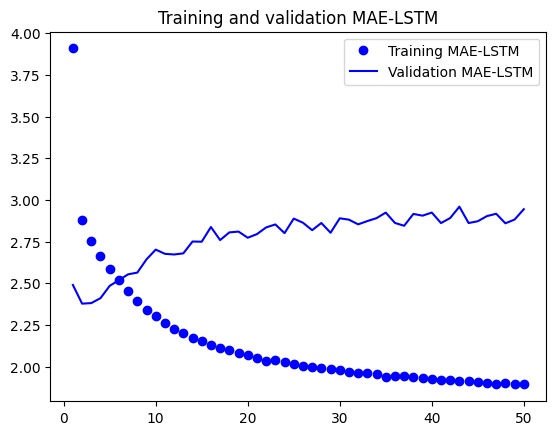

In [11]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE-LSTM")
plt.plot(epochs, val_loss, "b", label="Validation MAE-LSTM")
plt.title("Training and validation MAE-LSTM")
plt.legend()
plt.show()

**Combining 1D ConvNet and RNN**

In [10]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))

# 1D Convolutional layers
x = layers.Conv1D(32, 5, activation="relu")(inputs)
x = layers.MaxPooling1D(3)(x)
x = layers.Conv1D(32, 5, activation="relu")(x)
x = layers.MaxPooling1D(3)(x)
x = layers.Conv1D(32, 5, activation="relu")(x)

# LSTM layer
x = layers.LSTM(32, dropout=0.5)(x)

x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)

model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("combined_conv_rnn_model.keras",
                                    save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("combined_conv_rnn_model.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/50
819/819 [==============================] - 89s 105ms/step - loss: 27.9265 - mae: 3.9883 - val_loss: 13.8064 - val_mae: 2.9014
Epoch 2/50
819/819 [==============================] - 85s 103ms/step - loss: 16.3973 - mae: 3.1378 - val_loss: 13.8314 - val_mae: 2.9164
Epoch 3/50
819/819 [==============================] - 85s 104ms/step - loss: 14.6701 - mae: 2.9597 - val_loss: 13.5833 - val_mae: 2.8879
Epoch 4/50
819/819 [==============================] - 87s 106ms/step - loss: 13.4919 - mae: 2.8307 - val_loss: 13.8881 - val_mae: 2.9187
Epoch 5/50
819/819 [==============================] - 87s 106ms/step - loss: 12.5859 - mae: 2.7287 - val_loss: 12.9645 - val_mae: 2.8310
Epoch 6/50
819/819 [==============================] - 83s 101ms/step - loss: 11.8717 - mae: 2.6476 - val_loss: 13.5511 - val_mae: 2.8930
Epoch 7/50
819/819 [==============================] - 89s 109ms/step - loss: 11.3413 - mae: 2.5829 - val_loss: 15.8895 - val_mae: 3.1188
Epoch 8/50
819/819 [=====================

Plotting Model

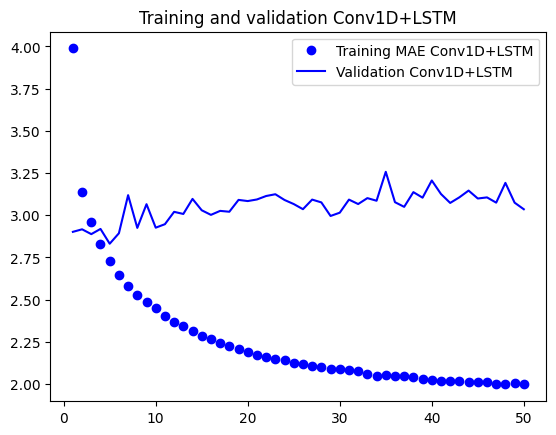

In [11]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE Conv1D+LSTM")
plt.plot(epochs, val_loss, "b", label="Validation Conv1D+LSTM")
plt.title("Training and validation Conv1D+LSTM")
plt.legend()
plt.show()

**Changing the Amount of Dropout**

***Less dropout***

In [12]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, recurrent_dropout=0.2, return_sequences=True)(inputs)
x = layers.GRU(32, recurrent_dropout=0.2)(x)
outputs = layers.Dense(1)(x)

model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_gru_less_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_stacked_gru_less_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/50
819/819 [==============================] - 342s 407ms/step - loss: 19.6896 - mae: 3.1996 - val_loss: 10.0074 - val_mae: 2.4700
Epoch 2/50
819/819 [==============================] - 331s 403ms/step - loss: 9.1339 - mae: 2.3577 - val_loss: 9.2748 - val_mae: 2.3630
Epoch 3/50
819/819 [==============================] - 331s 404ms/step - loss: 8.2816 - mae: 2.2540 - val_loss: 9.4088 - val_mae: 2.3817
Epoch 4/50
819/819 [==============================] - 330s 402ms/step - loss: 7.5388 - mae: 2.1516 - val_loss: 10.0186 - val_mae: 2.4653
Epoch 5/50
819/819 [==============================] - 334s 408ms/step - loss: 6.8699 - mae: 2.0546 - val_loss: 10.3684 - val_mae: 2.5090
Epoch 6/50
819/819 [==============================] - 332s 405ms/step - loss: 6.2993 - mae: 1.9679 - val_loss: 10.8898 - val_mae: 2.5650
Epoch 7/50
819/819 [==============================] - 332s 404ms/step - loss: 5.8036 - mae: 1.8897 - val_loss: 11.1821 - val_mae: 2.6028
Epoch 8/50
819/819 [======================

Plotting Model

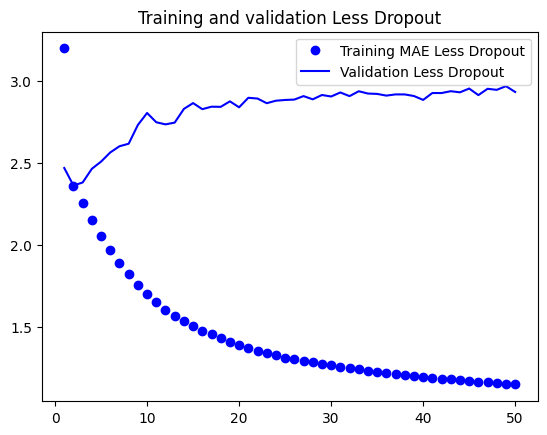

In [14]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE Less Dropout")
plt.plot(epochs, val_loss, "b", label="Validation Less Dropout")
plt.title("Training and validation Less Dropout")
plt.legend()
plt.show()

***More dropout***

In [14]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, recurrent_dropout=0.7, return_sequences=True)(inputs)
x = layers.GRU(32, recurrent_dropout=0.7)(x)
x = layers.Dropout(0.7)(x)
outputs = layers.Dense(1)(x)

model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout_updated.keras", save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

history = model.fit(train_dataset, epochs=50, validation_data=val_dataset, callbacks=callbacks)

model = keras.models.load_model("jena_stacked_gru_dropout_updated.keras")


Epoch 1/50
819/819 [==============================] - 355s 424ms/step - loss: 29.2533 - mae: 4.0476 - val_loss: 11.7695 - val_mae: 2.6694
Epoch 2/50
819/819 [==============================] - 341s 415ms/step - loss: 19.2693 - mae: 3.3643 - val_loss: 9.3274 - val_mae: 2.3628
Epoch 3/50
819/819 [==============================] - 341s 416ms/step - loss: 18.1398 - mae: 3.2654 - val_loss: 9.5822 - val_mae: 2.4091
Epoch 4/50
819/819 [==============================] - 340s 415ms/step - loss: 17.2154 - mae: 3.1774 - val_loss: 8.8383 - val_mae: 2.3021
Epoch 5/50
819/819 [==============================] - 340s 414ms/step - loss: 16.3783 - mae: 3.1037 - val_loss: 9.4005 - val_mae: 2.3854
Epoch 6/50
819/819 [==============================] - 379s 462ms/step - loss: 15.7066 - mae: 3.0390 - val_loss: 9.1222 - val_mae: 2.3477
Epoch 7/50
819/819 [==============================] - 338s 412ms/step - loss: 15.1067 - mae: 2.9848 - val_loss: 9.3566 - val_mae: 2.3852
Epoch 8/50
819/819 [====================

In [15]:
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 [==============================] - 44s 106ms/step - loss: 9.5467 - mae: 2.4217
Test MAE: 2.42


**Plotting model**

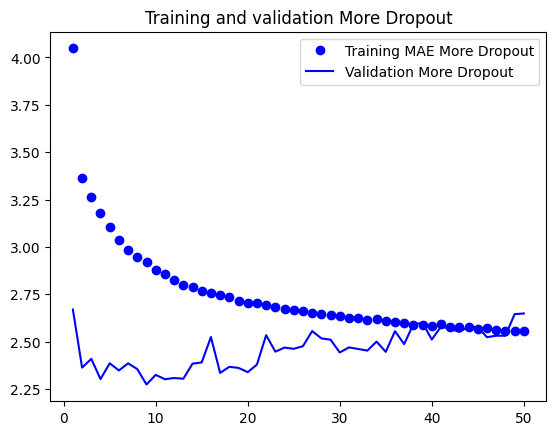

In [17]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE More Dropout")
plt.plot(epochs, val_loss, "b", label="Validation More Dropout")
plt.title("Training and validation More Dropout")
plt.legend()
plt.show()

**Using Adam and adjusting layers as well as dropout rate**

In [11]:
from tensorflow import keras
from tensorflow.keras import layers

# Define model architecture
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(64, return_sequences=True)(inputs)  # Increased GRU units
x = layers.GRU(32)(x)
x = layers.Dropout(0.2)(x)  # Reduced dropout rate
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

# Compile the model with optimized optimizer and learning rate
optimizer = keras.optimizers.Adam(learning_rate=0.001)  # Adjusted learning rate
model.compile(optimizer=optimizer, loss="mse", metrics=["mae"])

# Define callbacks for model training
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_gru_best_model.keras",
                                    save_best_only=True)
]

# Train the model with optimized parameters
history = model.fit(train_dataset,
                    epochs=50,  # Adjusted number of epochs
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/50
819/819 [==============================] - 391s 472ms/step - loss: 25.2247 - mae: 3.6578 - val_loss: 10.4221 - val_mae: 2.4461
Epoch 2/50
819/819 [==============================] - 396s 483ms/step - loss: 10.6104 - mae: 2.5320 - val_loss: 9.3246 - val_mae: 2.3583
Epoch 3/50
819/819 [==============================] - 413s 503ms/step - loss: 9.1687 - mae: 2.3674 - val_loss: 9.5142 - val_mae: 2.3900
Epoch 4/50
819/819 [==============================] - 381s 465ms/step - loss: 8.1297 - mae: 2.2348 - val_loss: 10.2031 - val_mae: 2.4770
Epoch 5/50
819/819 [==============================] - 396s 483ms/step - loss: 6.8407 - mae: 2.0397 - val_loss: 10.9892 - val_mae: 2.5892
Epoch 6/50
819/819 [==============================] - 395s 482ms/step - loss: 5.6235 - mae: 1.8429 - val_loss: 12.2394 - val_mae: 2.7148
Epoch 7/50
819/819 [==============================] - 395s 482ms/step - loss: 4.7557 - mae: 1.6892 - val_loss: 12.5329 - val_mae: 2.7497
Epoch 8/50
819/819 [=====================

In [13]:
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 [==============================] - 67s 165ms/step - loss: 13.1150 - mae: 2.8568
Test MAE: 2.86


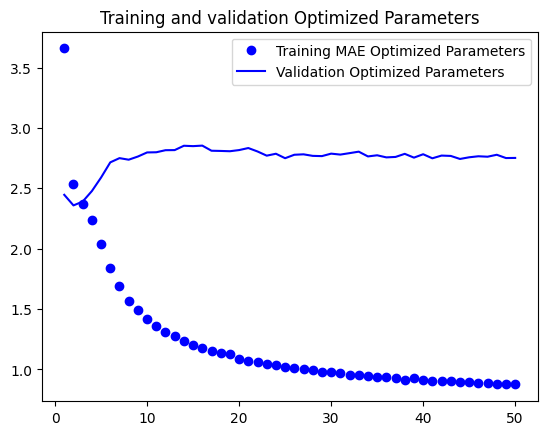

In [14]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE Optimized Parameters")
plt.plot(epochs, val_loss, "b", label="Validation Optimized Parameters")
plt.title("Training and validation Optimized Parameters")
plt.legend()
plt.show()